**Homework 3**

Javier Mencia

First we load the datasets

In [276]:
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt
import pandas as pd

url = 'https://raw.githubusercontent.com/javmencia/STA365javierMencia/main/UCICyclists%20(2).csv'
url2= "https://raw.githubusercontent.com/javmencia/STA365javierMencia/main/baseball_hitting.csv"
data = pd.read_csv(url, on_bad_lines='skip')

(array([  1.,  10.,  53., 112., 153., 238., 122.,  78.,  14.,   4.]),
 array([1.58 , 1.624, 1.668, 1.712, 1.756, 1.8  , 1.844, 1.888, 1.932,
        1.976, 2.02 ]),
 <BarContainer object of 10 artists>)

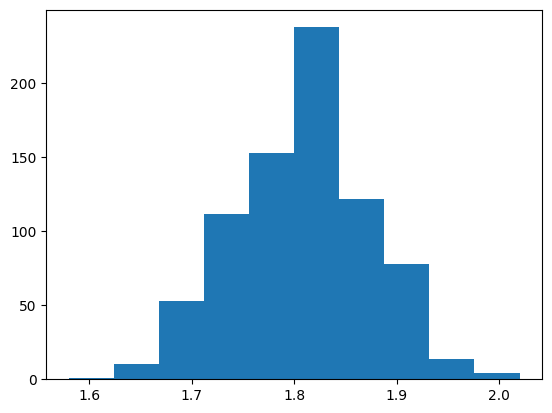

In [279]:
#Visualising height of cyclists column
height = data["Height(m)"]

plt.hist(height)


Here we observe that the height of cyclists appears to follow a normal distribution centered at 1.81m.

In [281]:
#Calculate parameters theta and phi
theta_true = np.sum(height) / len(height)
phi_true = np.std(height)

print(theta_true, phi_true)

1.8070828025477705 0.06491169521423099


Text(0.5, 1.0, 'Observed Data and True Data Distribution')

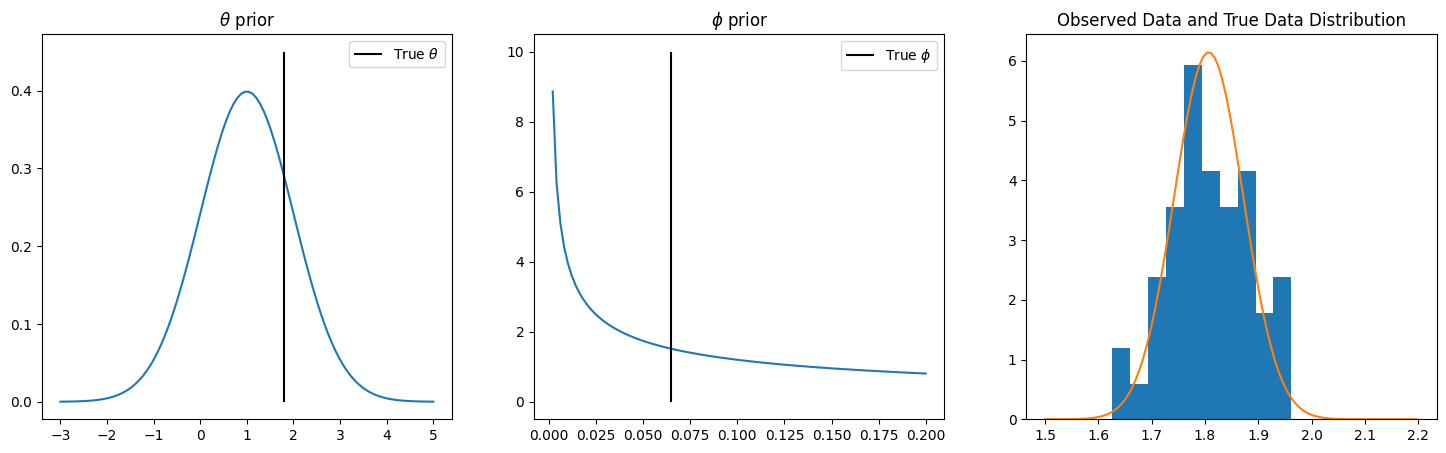

In [282]:
# Priors and Hyperparameters
theta_0,tau = 1,1; alpha,beta = 0.5,1/2
theta_prior = stats.norm(loc=theta_0, scale=tau)
phi_prior = stats.gamma(a=alpha, scale=1/beta)

#Initialising true data model
true_data_model = stats.norm(loc=theta_true,scale=phi_true)
n = 50; np.random.seed(seed=123); x = true_data_model.rvs(n);

#Plot for theta
Rplus = np.linspace(0,0.2,100); Rpm = np.linspace(-3,5,100)
fig,ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(Rpm, theta_prior.pdf(Rpm))
ax[0].set_title('$\\theta$ prior')
ax[0].vlines(theta_true,0,.45,'k',label='True $\\theta$')
ax[0].legend()

#Plot for phi
ax[1].plot(Rplus, phi_prior.pdf(Rplus))
ax[1].vlines(phi_true,0,10,'k',label='True $\\phi$')
ax[1].legend(); ax[1].set_title('$\\phi$ prior')

#Observed data and true data
Rpm = np.linspace(1.5,2.2,100)
ax[2].hist(x, density=True)
ax[2].plot(Rpm, true_data_model.pdf(Rpm))
ax[2].set_title('Observed Data and True Data Distribution')

Text(0.5, 1.0, 'Distribution of proportion of hits per at bat')

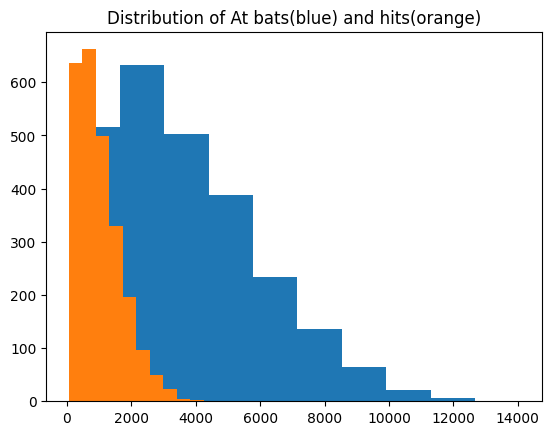

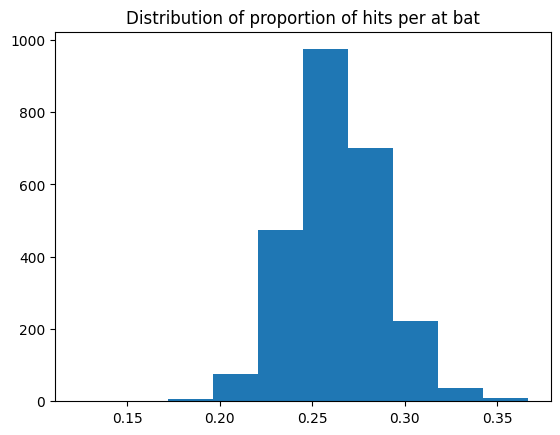

In [286]:
data = pd.read_csv(url2, on_bad_lines='skip')
hits = data["Hits"]
atbat = data["At-bat"]

plt.hist(atbat)
plt.hist(hits)
plt.title("Distribution of At bats(blue) and hits(orange)")

hitsperatbat = hits/atbat
plt.figure()
plt.hist(hitsperatbat)
plt.title("Distribution of proportion of hits per at bat")

This data follows a binomial distribution, since we are looking at the number of successes(hits) in a sequence of independent trials(at bats)

In [287]:
# Create model and samples
import pymc as pm
import arviz as az

bin_model = pm.Model()
#Bin(n, p)

with bin_model:
    total = len(hits)
    p = pm.Normal("p", mu=0.25, sigma = 0.25)
    x_obs = pm.Binomial("likelihood", n=total, p = p, observed=x)

with bin_model:
    idata_HMC = pm.sample(chains = 4)



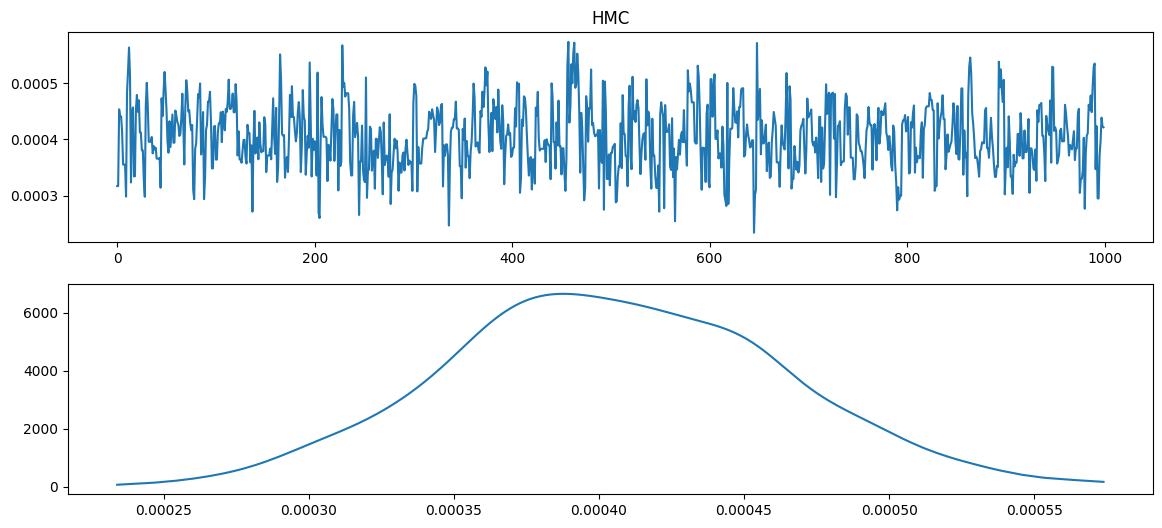

In [270]:
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,1, figsize=(14,6))
n_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["p"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0].plot(mcmc_chain); ax[1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0].set_title("HMC");


In [271]:
import arviz as az; print("number of MCMC samples:", idata_HMC.posterior['p'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2) # https://python.arviz.org/en/stable/api/generated/arviz.ess.html

number of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.0,0.0,0.0,0.0,0.0,0.0,1422.71,2416.59,1.0


We see there that r_hat is lower than 1.05, so we can assume the Markov chain converges and the samples are representative of the stationary distributions.

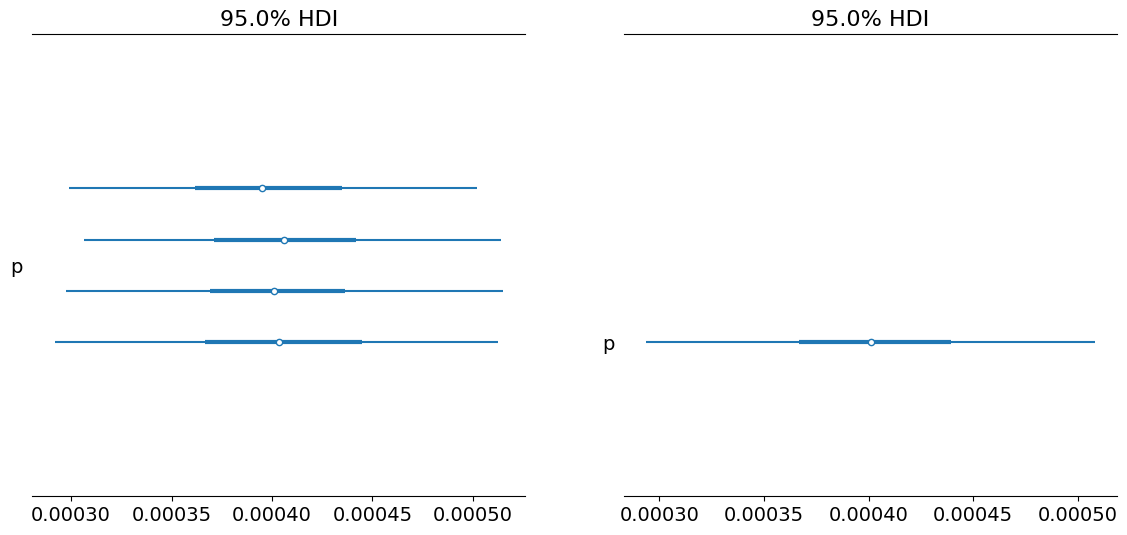

In [275]:
import arviz as az; import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["p"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_HMC, var_names=["p"], combined=True, hdi_prob=0.95, ax=ax[1]);


On the left, we see the 95% HDI of the Markov chains separetely and on the right, the combined one